# F1 Tire Degradation Modeling & Pit Strategy Optimization

## 1. Problem Statement

Formula 1 (F1) is a very competitive motor sport and the margin for victory can sometimes be razor thin.  For example, for the 2025 season, Lando Norris won the championship with 423 points versus Max Verstappen’s 421 points.   The championship title was decided in the season’s last race (Abi Dhabi), and yet it could have been secured earlier, a race before, if it were not for two errors – a car specification disqualification in Las Vegas, and a pit stop strategy blunder in Qatar.

For this project, I will focus pit stop strategy by answering this question, “As a F1 Team Principal, when should we pit?”.   I propose answering this question by building a race simulator and pit strategy optimizer that answers the question each lap, should we pit now, or wait?   In the case of the 2025 Qatar race, when the Safety Car was deployed on lap 7, the pit strategy optimizer may have answered the question, “yes”, pit immediately.

The goal is of the project is to focus on F1 pit strategy in the face of tire degradation, available tires, tire usage rules, and the uncertainty of traffic, safety car deployment and decisions made by the other teams.    There are several potential opportunities for use of regression or ML techniques including but not limited to:
    - tire degredation modeling
    - fule consumption
    - race simulation efficiency
    - and decision analysis

The notebook includes:
- Data exploration
- Tire degradation modeling
- Model validation and comparison
- Pit strategy optimization and decision analysis
- Final insights and recommendations

## 2. Data Sources & Structure

- Data - the project uses race result data from https://docs.fastf1.dev/, which takes actual F1 race lap times and wraps it into Python dataframes
- The dataset - contains F1 race information going back to 2018
- Key columns are - (year, race, driver, lap number, tire compound, lap time, lap status, finish times)
- Assumptions, limitations, concerns, investigations - Understanding of relationship between official F1 timing data and fastf1 data, completeness of fast1 data

**Accessing the fastf1 api, for the 2025 Qatar GrandPrix, Race Session.**

## 3. Exploratory Data Analysis (EDA), Investigation, Industry Knowledge

Items to Explore and Understand:
    - Nature of fastf1.api
    - F1 race rules - tire compound usage - safety car deployment
    - Lap time distributions
    - Tire compound differences
    - Race Stint lengths
    - Degradation patterns

In [78]:
"""Let's start with assessing the fastf1 package/api"""

import fastf1 #import fastf1 package
import pandas as pd

# Set up cache, recommended by fastf1 documentation
fastf1.Cache.enable_cache('/Users/jeffreylgoode/documents/f1-capstone-project')

# Load a race session with year, event/race venue, and session type (Race, Qualifying, etc), use race designator R, versus Q for qualifying
session = fastf1.get_session(2025, 'Qatar Grand Prix', 'R')
session.load()

# Pick a driver (VER = Max Verstappen) for driver specific lap data
laps = session.laps.pick_drivers('VER')

laps.info()

events      WARNING 	Correcting user input 'Qatar Grand Prix' to 'Qatar Grand Prix'
core           INFO 	Loading data for Qatar Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '81', '55', '4', '12', '63', '14', '16', '30', '22', '23', '44', '5', '43', '31', '10', '18

<class 'fastf1.core.Laps'>
Index: 57 entries, 0 to 56
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   Time                57 non-null     timedelta64[ns]
 1   Driver              57 non-null     object         
 2   DriverNumber        57 non-null     object         
 3   LapTime             57 non-null     timedelta64[ns]
 4   LapNumber           57 non-null     float64        
 5   Stint               57 non-null     float64        
 6   PitOutTime          2 non-null      timedelta64[ns]
 7   PitInTime           2 non-null      timedelta64[ns]
 8   Sector1Time         56 non-null     timedelta64[ns]
 9   Sector2Time         57 non-null     timedelta64[ns]
 10  Sector3Time         57 non-null     timedelta64[ns]
 11  Sector1SessionTime  55 non-null     timedelta64[ns]
 12  Sector2SessionTime  57 non-null     timedelta64[ns]
 13  Sector3SessionTime  57 non-null     timedelta64[ns]
 

In [76]:
laps.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 01:00:10.717000,VER,1,0 days 00:01:28.940000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:29.257000,...,True,Red Bull Racing,0 days 00:58:41.498000,2025-11-30 16:03:27.173,1,2.0,False,,False,False
1,0 days 01:01:38.066000,VER,1,0 days 00:01:27.349000,2.0,1.0,NaT,NaT,0 days 00:00:32.280000,0 days 00:00:29.444000,...,True,Red Bull Racing,0 days 01:00:10.717000,2025-11-30 16:04:56.392,1,2.0,False,,False,True
2,0 days 01:03:05.577000,VER,1,0 days 00:01:27.511000,3.0,1.0,NaT,NaT,0 days 00:00:32.250000,0 days 00:00:29.509000,...,True,Red Bull Racing,0 days 01:01:38.066000,2025-11-30 16:06:23.741,1,2.0,False,,False,True
3,0 days 01:04:32.901000,VER,1,0 days 00:01:27.324000,4.0,1.0,NaT,NaT,0 days 00:00:32.285000,0 days 00:00:29.460000,...,True,Red Bull Racing,0 days 01:03:05.577000,2025-11-30 16:07:51.252,1,2.0,False,,False,True
4,0 days 01:05:59.744000,VER,1,0 days 00:01:26.843000,5.0,1.0,NaT,NaT,0 days 00:00:32.064000,0 days 00:00:29.529000,...,True,Red Bull Racing,0 days 01:04:32.901000,2025-11-30 16:09:18.576,1,2.0,False,,False,True


In [83]:
laps.tail()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
52,0 days 02:17:41.564000,VER,1,0 days 00:01:24.492000,53.0,3.0,NaT,NaT,0 days 00:00:31.203000,0 days 00:00:28.870000,...,True,Red Bull Racing,0 days 02:16:17.072000,2025-11-30 17:21:02.747,1,1.0,False,,False,True
53,0 days 02:19:06.242000,VER,1,0 days 00:01:24.678000,54.0,3.0,NaT,NaT,0 days 00:00:31.444000,0 days 00:00:28.818000,...,True,Red Bull Racing,0 days 02:17:41.564000,2025-11-30 17:22:27.239,1,1.0,False,,False,True
54,0 days 02:20:30.647000,VER,1,0 days 00:01:24.405000,55.0,3.0,NaT,NaT,0 days 00:00:31.193000,0 days 00:00:28.942000,...,True,Red Bull Racing,0 days 02:19:06.242000,2025-11-30 17:23:51.917,1,1.0,False,,False,True
55,0 days 02:21:55.050000,VER,1,0 days 00:01:24.403000,56.0,3.0,NaT,NaT,0 days 00:00:31.098000,0 days 00:00:28.598000,...,True,Red Bull Racing,0 days 02:20:30.647000,2025-11-30 17:25:16.322,1,1.0,False,,False,True
56,0 days 02:23:20.018000,VER,1,0 days 00:01:24.968000,57.0,3.0,NaT,NaT,0 days 00:00:31.585000,0 days 00:00:28.789000,...,True,Red Bull Racing,0 days 02:21:55.050000,2025-11-30 17:26:40.725,1,1.0,False,,False,True


**We can see that the final race lap number is 57.**

**Now xxplore laps per tire compound.**

In [82]:
df = laps.copy()

# Keep only valid laps
df["lap_time"] = df["LapTime"].dt.total_seconds()
df = df[df["lap_time"] > 0]

# Count laps per compound
lap_counts = df["Compound"].value_counts().reset_index()
lap_counts.columns = ["Compound", "LapCount"]

print(lap_counts)


  Compound  LapCount
0   MEDIUM        32
1     HARD        25


**For the 2025 Qatar GrandPrix, Max Verstappen ran 32 laps on the Medium tire compound, and 25 laps on the Soft tire compound**

Answering the question of when to pit depends on the tire
compound strategy chosen, and well as Safety Car (SC), or Virtual Safety Car(VSC) deployment.
Next, let's evaluatate for the 2025 Qatar race if any SC or VSC were deployed.

In [84]:
#fast f1 captures track status in the .track_status method on session
ts = session.track_status
print(ts.head())


                    Time Status     Message
0        0 days 00:00:00      1    AllClear
1 0 days 01:07:59.807000      2      Yellow
2 0 days 01:08:16.036000      4  SCDeployed
3 0 days 01:16:03.334000      1    AllClear


**From above, we can see that a yelllow occured at a specific time, followed by deployment of a Safety Car, followed by the "All Clear Given".**

Later we will need to merge lap times with track status to map SC or VSC deployment to laps, and all determine explicitly when pit stops occured.

**Now let's code a block to determine race finish time for Max as well as other
information, like lap number, tire stints, speed trap measurements, tire compound, team name.**

In [88]:
ver_laps = laps.pick_drivers('VER')

# Last lap entry
ver_final_lap = ver_laps.iloc[-1]

finish_time = ver_final_lap['Time']

print("Max Verstappen finish time:", finish_time)
ver_final_lap.info


Max Verstappen finish time: 0 days 02:23:20.018000


<bound method Series.info of Time                      0 days 02:23:20.018000
Driver                                       VER
DriverNumber                                   1
LapTime                   0 days 00:01:24.968000
LapNumber                                   57.0
Stint                                        3.0
PitOutTime                                   NaT
PitInTime                                    NaT
Sector1Time               0 days 00:00:31.585000
Sector2Time               0 days 00:00:28.789000
Sector3Time               0 days 00:00:24.594000
Sector1SessionTime        0 days 02:22:26.661000
Sector2SessionTime        0 days 02:22:55.450000
Sector3SessionTime        0 days 02:23:20.044000
SpeedI1                                    244.0
SpeedI2                                    288.0
SpeedFL                                    246.0
SpeedST                                    309.0
IsPersonalBest                             False
Compound                                

**Let's start with accessing the fastf1.api for a race that I watched this past year.  A single per lap time plot for a single race
for a single driver exposes the challenges of the project.**

events      WARNING 	Correcting user input 'Qatar' to 'Qatar Grand Prix'
core           INFO 	Loading data for Qatar Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '81', '55', '4', '12', '63', '14', '16', '30', '22', '23', '44', '5', '43', '31', '10', '18', '6', '87

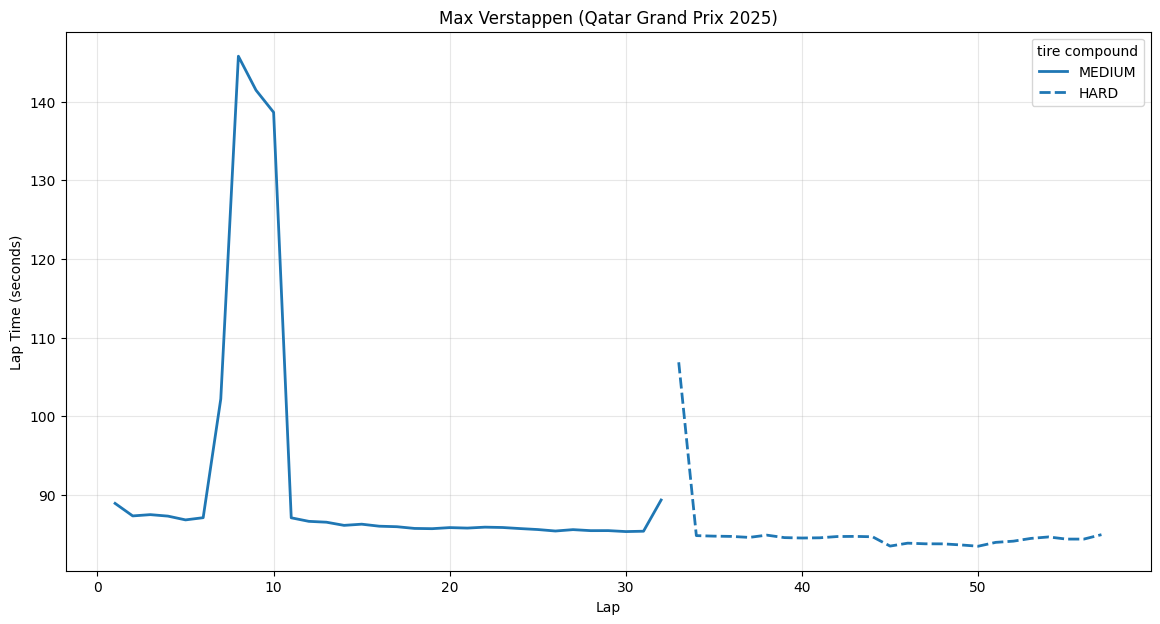

In [90]:
import fastf1 # fast f1 api
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure cache exists, this is recommended by fastf1 to speed up analayis after the initial data load
os.makedirs("fastf1_cache", exist_ok=True)
fastf1.Cache.enable_cache("fastf1_cache")

# Load 2025 Austin Race, US GrandPrix, "R" stands for Race versus qualifying, practice1, etc.
session = fastf1.get_session(2025, "Qatar", "R")
session.load()

# Extract Max Verstappen's laps
laps_ver = session.laps.pick_drivers("VER")

# Build clean DataFrame, with only the data we need
df_max = laps_ver[["LapNumber", "LapTime", "Compound", "TrackStatus"]].copy()

# Convert LapTime (timedelta) → seconds
df_max["lap_time"] = df_max["LapTime"].dt.total_seconds()

# Rename for consistency
df_max.rename(columns={"LapNumber": "lap", "Compound": "tire compound"}, inplace=True)

# Remove invalid laps (out-laps, in-laps, SC laps)
df_max = df_max[df_max["lap_time"] > 0]


plt.figure(figsize=(14, 7))

# Main lap-time line
sns.lineplot(
    data=df_max,
    x="lap",
    y="lap_time",
    style="tire compound",
    linewidth=2
)

plt.title("Max Verstappen (Qatar Grand Prix 2025)")
plt.xlabel("Lap")
plt.ylabel("Lap Time (seconds)")
plt.grid(alpha=0.3)
plt.show()



In [87]:
import fastf1
import pandas as pd
import os

# ---------------------------------------------------------
# 1. Enable cache and load a race session
# ---------------------------------------------------------
os.makedirs("fastf1_cache", exist_ok=True)
fastf1.Cache.enable_cache("fastf1_cache")

session = fastf1.get_session(2025, "United States", "R")
session.load()

# ---------------------------------------------------------
# 2. Identify the race leader (P1 on Lap 1)
# ---------------------------------------------------------
lap1 = session.laps[session.laps["LapNumber"] == 1]
leader = lap1.sort_values("Position").iloc[0]["Driver"]

# Get leader's laps (best reference for LapStartTime)
leader_laps = session.laps.pick_drivers(leader)[["LapNumber", "LapStartTime"]].copy()

# ---------------------------------------------------------
# 3. Get full track status timeline
# ---------------------------------------------------------
ts = session.track_status.copy()   # columns: Time, Status

# ---------------------------------------------------------
# 4. Convert track-status timestamps → lap numbers
# ---------------------------------------------------------
def timestamp_to_lap(ts_time, laps_df):
    """
    Map a timestamp (ts_time) to the lap that was active at that moment.
    """
    mask = laps_df["LapStartTime"] <= ts_time
    if not mask.any():
        return None  # before race start
    return laps_df.loc[mask, "LapNumber"].max()

ts["LapNumber"] = ts["Time"].apply(lambda t: timestamp_to_lap(t, leader_laps))

# Remove entries before race start
ts = ts.dropna(subset=["LapNumber"])
ts["LapNumber"] = ts["LapNumber"].astype(int)

# ---------------------------------------------------------
# 5. Extract SC and VSC laps
# ---------------------------------------------------------
# FIA codes:
# 4 = Safety Car
# 5 = VSC deployed
# 6 = VSC ending

sc_laps = ts[ts["Status"] == "4"]["LapNumber"].unique()
vsc_laps = ts[ts["Status"].isin(["5", "6"])]["LapNumber"].unique()

print("Race leader:", leader)
print("Safety Car laps:", sc_laps)
print("Virtual Safety Car laps:", vsc_laps)


events      WARNING 	Correcting user input 'United States' to 'United States Grand Prix'
core           INFO 	Loading data for United States Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '16', '44', '81', '63', '22', '27', '87', '14', '30', '18', '12', '23', '

Race leader: VER
Safety Car laps: []
Virtual Safety Car laps: [7]


**Analysis and commentary on above**

The plot above shows lap time in seconds for the entirety of the race.  It shows the change in tire compound at lap 33, from Medium compound to Soft compound tires.  When the tires are changed at lap 33, the lap time jumps up to approximately 118 seconds.  This is called the pit loss, since the car has to enter pit lane, tires are changed, and then exits the pit.  The change in laptime at approximately lap 7 (I rewatched the race) was due to a Virtual Safety car which was deployed because of an accident.  Going forward, Saftey Cars, and Virtual Safety Car information will be shown explicitly.

Of note is the nominal lap time difference between the Medium and Soft tires, the Medium is slower, the Soft is faster, lap times are less.

In [ ]:
sns.lineplot(data=df, x="lap_number", y="lap_time", hue="compound")
plt.title("Lap Time vs Lap Number by Compound")
plt.show()

# 4. Approach - Simulator, Optimizer, Future Opportunties for regression or ML

The approach for answering the question, when should I pit requires a system approach.  F1 teams have access to fastf1 data as well as their own recorded car telemetry for each race venue, and likely for several years.  Utlimately as each F1 team approaches a race weekend, they will be using practive and qualifying data to tune a race day strategy, fuel load, tire compound, analysis of prior race Safety Car deployments, as well as evaluating what other teams did on race day.

Here's a resource/primer on how F1 teams prepare for race day, https://michaelluzich.com/how-f1-teams-prepare-for-a-grand-prix-weekend/

Upon reviewing this source, and having watched dozens of F1 races over the years, and upon reviewing other soruces of how F1 teams operate, I've chosen the following approach to answering the question, "Should we pit now?", or "stay out?".

My approach is as follows:

- Build a race simulator that has inputs of total laps, a simple model for tire degradation and pit loss
- Perform a sanity check of above using fastf1
- Build a strategy optimizer which iterates through all "legal" possible tire compond strategies. By legal, F1 has some rules for tire usage and pitting

My working theory, is that a F1 team principal would use the simulator and optimizer before race day to select a plan A, B, and C for tire compound strategies that have been informed by Safety Car probabilities.  Then, as the race unfolds, the optimizer would rerun candidate strategies based on real time conditions.  For example, "we are at lap 7, and a Safety Car was just deployed, what are our best strategy options going forward?".

From my research, ML could be used to help with downselection strategy options in the heat of the moment, versus a total rerun of the race simulator with the candidate options.   This is to be yet determined.





# 4. Tire Degradation Modeling

## 4.1 Initial Race Lap Simulator with linear tire degradation

This code represents an initial version of a race lap simulator with a simple model for tire degredation.
Though simple, one can see from the plots the complexity of choosing a pit strategy,
as part of answering the question, when do we pit?
1. Tire degredation is measured in a tire_age * degredation/lap approach
2. A strategy structure was defined
3. Includes pit stop loss when tires are changed
4. Safety Cars (SC) and Virtual Safety Car (VSC) were not introduced

In [ ]:
import numpy as np
import pandas as pd

# ------------------------------------------------------------
# 1. Simple lap time model
# ------------------------------------------------------------

"""
Use of an actual race simulator, calling an API was explored, but the following approach was taken, "build my own" to help
provide a basic understanding of the components of lap time.

This is the simplest of models that will allow us to start.  Our pit strategy optimizer will provide this model with
a pit strategy.  Pit strategy is defined as follows,

1. What tire do I start the race with?
2. When do I pit?
3. What compound (tire type) do I switch to?
4. When do I pit again?

An optimal pit strategy will minimize lap times and ultimately result in the fastest race total time.
The race lap and total time simulator will allow us to try different compounds and pit time (which lap to pit on) to compare and visualize results

A stint is defined as the time frame that a particular tire compound in use

lap time = base_lap_time + compound_offset + degradation_rate per lap * tire age in laps, all in seconds

Initially we will only concern ourselves with races run in the dry,
so we don't need to model intermediate or wet tires, only soft, medium and hard compound tires

Soft tires are the fastest since they are sticky, but degrade quickly,
Hard tires degrade at the slowest rate, they last a long time, but are the slowest
Medium tires set in the middle of these two for speed and degradation.

Below Soft = S, Medium = M, Hard = H

A strategy example for Austin TX would be to start on Soft, Pit at Lap 18, then switch to Medium tires to complete the race
The short hand for this would be Soft -> Medium
"""

# To get a handle on the results, we will use the Austin TX venue
AUSTIN_BASE_LAP = 93 # the base lap time for the Austin TX venue is 93 seconds
AUSTIN_PIT_LOSS = 24 # this is the amount of time that is lost in the pit lane entrance, pit, and exit
AUSTIN_TOTAL_LAPS = 56 # total laps for Austin Race
TOTAL_LAPS = AUSTIN_TOTAL_LAPS
BASE_LAP_TIME = AUSTIN_BASE_LAP  # seconds, US Gran Prix Austin TX baseline


TIRE_COMPOUND_OFFSETS = {
    "S": -1.2,   # Softs are fastest, this is the amount per lap where softs improve the baseline performance
    "M": 0.0,    # Medium tire baseline
    "H": +1.5    # Hards are slowest, this is the amount per lap where hard tires add take away from baseline performance
}


TIRE_DEGRADATION_RATES = {
    "S": 0.12,  # Softs degrade fastest,
    "M": 0.08,  # Medium tires degrade at a rate that's between Softs and Hards
    "H": 0.05   # degrade at a rate that is slowest
}

PIT_LOSS = AUSTIN_PIT_LOSS

#define a function that returns the elapsed time for a lap given inputs tire compound and tire age

def lap_time(tire, tire_age):
    return (
        BASE_LAP_TIME
        + TIRE_COMPOUND_OFFSETS[tire]
        + TIRE_DEGRADATION_RATES[tire] * tire_age
    )


# ------------------------------------------------------------
# 2. Simulator
# ------------------------------------------------------------


# now pass in strategy
# a strategy can be starting compound, pit lap, next compound
# when lap count hits pit lap, a pit loss is added, the next lap switches to next compound
# so ("S", 18, "M"), would be a strategy for one stop.
# let's build it for one stop,
# we can define a tuple with a name, first compound, pit stop lap, the next compound

#put in a test to ensure all laps add up to less than the total laps for the race venue
# also extend strategies like below
"""

loop through a strategy stint to ensure lap count does not exceed race total, ultimately decided not to implement
this, since the optimizer will likely be built to test for correct strategies before the simulator is called.
"""

strategy = [
    {"tire": "S", "laps": 18}, # indicates tire compound and laps till pit to change
    {"tire": "M", "laps": 28},
    {"tire": "S", "laps": None}   # final stint
]


#for stint in strategy:
#    print(stint["tire"], stint["laps"])

# now extend the strategy list by building a new list that will bracket stints by lap number
def expand_strategy(strategy, TOTAL_LAPS):

    stints = []
    current_lap = 1

    for stint in strategy:
        tire = stint["tire"]
        laps = stint["laps"]

        if laps is None:
                # final stint goes to end of race
            end_lap = TOTAL_LAPS
        else:
            end_lap = current_lap + laps - 1
        #print(stint)
        stints.append({
            "tire": tire,
            "start": current_lap,
            "end": end_lap
        })
        #print(stints)
        current_lap = end_lap + 1

    return stints
#stints = expand_strategy(strategy, TOTAL_LAPS)
#print(stints)


stints = expand_strategy(strategy, TOTAL_LAPS)
print(stints)
#for stint in strategy:
#    print(stint)
lap_records = []

def total_race_time(strategy_name, strategy, TOTAL_LAPS):
    stints = expand_strategy(strategy, TOTAL_LAPS)
    total = 0
    delta_time = 0

    for stint in stints:
        tire = stint["tire"]
        for lap in range(stint["start"], stint["end"] + 1):
            tire_age = lap - stint["start"]
            delta_time = lap_time(tire, tire_age)
            if (lap == stint["end"] and stint["end"] != TOTAL_LAPS):
                delta_time += PIT_LOSS
            total += delta_time
            #print(f"lap {lap}, tire {tire}, delta_time {delta_time:.3f} cumulative time {total:.3f}")
            lap_records.append({ "strategy": strategy_name,"lap": lap, "tire": tire, "delta_time": delta_time, "cumulative_time": total})

    return total

strategy1 = [
    {"tire": "S", "laps": 18}, # indicates tire compound and laps till pit to change
    {"tire": "M", "laps": 28},
    {"tire": "S", "laps": None}   # final stint
]
strategy2 = [
    {"tire": "S", "laps": 30}, # indicates tire compound and laps till pit to change
    {"tire": "M", "laps": None}
]
strategy3 = [
    {"tire": "S", "laps": 20}, # indicates tire compound and laps till pit to change
    {"tire": "M", "laps": None}
]


total = total_race_time("Jeff", strategy1, TOTAL_LAPS)
total = total_race_time("Sam", strategy2, TOTAL_LAPS)
total_race_time("Tim", strategy3, TOTAL_LAPS)
df_laps = pd.DataFrame(lap_records)
#print(df_laps)
#print(total)


""" Experimentation with plots to review data
"""
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(data=df_laps, x="lap", y="delta_time", hue="tire")
plt.title("Lap Time by Lap Number")
plt.show()

sns.lineplot(data=df_laps, x="lap", y="delta_time", hue="strategy")
plt.title("Lap Time by Lap Number")
plt.show()


sns.lineplot(data=df_laps, x="lap", y="cumulative_time", hue="strategy")
plt.title("Cumulative Race Time")
plt.show()

g = sns.FacetGrid(df_laps, col="strategy", col_wrap=2, height=4, sharey=False)
g.map_dataframe(sns.lineplot, x="lap", y="cumulative_time")
g.set_titles("{col_name}")
plt.show()

df_final = (
    df_laps
    .groupby("strategy", as_index=False)
    .agg(final_time=("cumulative_time", "max"))
)

plt.figure(figsize=(8, 5))



ax = sns.barplot(
    data=df_final,
    x="strategy",
    y="final_time",
    hue="strategy",
    palette="tab10",
    legend=False
)


plt.ylim(df_final["final_time"].min() - 5,
         df_final["final_time"].max() + 5)

plt.title("Final Race Time by Strategy (Zoomed)")
plt.ylabel("Final Time (s)")

# Label ALL bars, not just the first container
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=3)

plt.show()



## 4.2 Refactor Race Simulator to accept programatic inputs from a brute force optimizer

Refactor code above so that a pit strategy optimizer can call it programmatically to iterate though strategy combinations in search of the best strategy for shortest race time.

In [ ]:
import pandas as pd

TOTAL_LAPS = 56          # later will have this as a race venue input
PIT_LOSS = 20.0          # later will have this as a race venue input

TIRE_COMPOUND_OFFSETS = {
    "S": -1.2,   # Softs are fastest, this is the amount per lap where softs improve the baseline performance
    "M": 0.0,    # Medium tire baseline
    "H": +1.5    # Hards are slowest, this is the amount per lap where hard tires add take away from baseline performance
}

TIRE_DEGRADATION_RATES = {
    "S": 0.12,  # Softs degrade fastest,
    "M": 0.08,  # Medium tires degrade at a rate that's between Softs and Hards
    "H": 0.05   # degrade at a rate that is slowest
}


#define a function that returns the elapsed time for a lap given inputs tire compound and tire age

def lap_time(tire, tire_age):
    return (
        BASE_LAP_TIME
        + TIRE_COMPOUND_OFFSETS[tire]
        + TIRE_DEGRADATION_RATES[tire] * tire_age
    )


# --------------------------------------------------
# 1. Strategy expansion (laps -> [start, end])
# --------------------------------------------------

def expand_strategy(strategy, total_laps):
    """
    Convert a stint-based strategy into explicit lap ranges.

    Input example:
        strategy = [
            {"tire": "S", "laps": 18},
            {"tire": "M", "laps": 28},
            {"tire": "S", "laps": None},  # final stint to race end
        ]

    Output example:
        [
            {"tire": "S", "start": 1,  "end": 18},
            {"tire": "M", "start": 19, "end": 46},
            {"tire": "S", "start": 47, "end": 56},
        ]
    """
    stints = []
    current_lap = 1

    for stint in strategy:
        tire = stint["tire"]
        laps = stint["laps"]

        if laps is None:
            # final stint goes to end of race
            end_lap = total_laps
        else:
            end_lap = current_lap + laps - 1

        stints.append({
            "tire": tire,
            "start": current_lap,
            "end": end_lap
        })

        current_lap = end_lap + 1

    return stints


# --------------------------------------------------
# 2. Pure simulation: total race time only
# --------------------------------------------------

def total_race_time(strategy, total_laps, pit_loss=PIT_LOSS):
    """
    Compute total race time for a given strategy.
    """
    stints = expand_strategy(strategy, total_laps)
    total = 0.0

    for stint in stints:
        tire = stint["tire"]
        start = stint["start"]
        end = stint["end"]

        for lap in range(start, end + 1):
            tire_age = lap - start
            lap_time_value = lap_time(tire, tire_age)

            # Add pit loss at end of stint, except final stint
            if lap == end and end != total_laps:
                lap_time_value += pit_loss

            total += lap_time_value

    return total


# --------------------------------------------------
# 3. Detailed simulation: lap-by-lap records
# --------------------------------------------------

def simulate_with_lap_data(strategy_name, strategy, total_laps, pit_loss=PIT_LOSS):
    """
    Same core logic as total_race_time, but returns lap-by-lap data
    for analysis and plotting.
    """
    stints = expand_strategy(strategy, total_laps)
    total = 0.0
    lap_records = []

    for stint in stints:
        tire = stint["tire"]
        start = stint["start"]
        end = stint["end"]

        for lap in range(start, end + 1):
            tire_age = lap - start
            lap_time_value = lap_time(tire, tire_age)

            # Add pit loss at end of stint, except final stint
            if lap == end and end != total_laps:
                lap_time_value += pit_loss

            total += lap_time_value

            lap_records.append({
                "strategy": strategy_name,
                "lap":      lap,
                "tire":     tire,
                "lap_time": lap_time_value,
                "cumulative_time": total
            })

    return total, lap_records


# --------------------------------------------------
# 4. Example strategies and usage
# --------------------------------------------------

strategy1 = [
    {"tire": "S", "laps": 18},
    {"tire": "M", "laps": 28},
    {"tire": "S", "laps": None}
]

strategy2 = [
    {"tire": "S", "laps": 30},
    {"tire": "M", "laps": None}
]

strategy3 = [
    {"tire": "S", "laps": 20},
    {"tire": "M", "laps": None}
]

# run if from Jupyter notebook, but don't run if called, imported by another program
if __name__ == "__main__":
    # Example: how a brute-force optimizer will use total_race_time
    t1 = total_race_time(strategy1, TOTAL_LAPS)
    t2 = total_race_time(strategy2, TOTAL_LAPS)
    t3 = total_race_time(strategy3, TOTAL_LAPS)

    print(f"Strategy1 total time: {t1:.3f}")
    print(f"Strategy2 total time: {t2:.3f}")
    print(f"Strategy3 total time: {t3:.3f}")
    # Example: detailed simulation for plotting, put all runs in this

    all_lap_records = []

# for strategy pair, use name to call name in simulate with lap time function
# then for loop calls function with strategy using the strat variable
# then all_lap_records is used to hold the laps info returned for each strategy
    for name, strat in [("Jeff", strategy1), ("Sam", strategy2), ("Tim", strategy3)]:
        total, laps = simulate_with_lap_data(name, strat, TOTAL_LAPS)
        all_lap_records.extend(laps)

    df_laps = pd.DataFrame(all_lap_records)
    print(df_laps.head())


In [ ]:

""" Experimentation with plots to review data
"""
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(data=df_laps, x="lap", y="lap_time", hue="tire")
plt.title("Lap Time by Lap Number")
plt.show()

sns.lineplot(data=df_laps, x="lap", y="lap_time", hue="strategy")
plt.title("Lap Time by Lap Number")
plt.show()

sns.lineplot(data=df_laps, x="lap", y="cumulative_time", hue="strategy")
plt.title("Cumulative Race Time")
plt.show()

g = sns.FacetGrid(df_laps, col="strategy", col_wrap=2, height=4, sharey=False)
g.map_dataframe(sns.lineplot, x="lap", y="cumulative_time")
g.set_titles("{col_name}")
plt.show()

df_final = (
    df_laps
    .groupby("strategy", as_index=False)
    .agg(final_time=("cumulative_time", "max"))
)

plt.figure(figsize=(8, 5))

ax = sns.barplot(
    data=df_final,
    x="strategy",
    y="final_time",
    hue="strategy",
    palette="tab10",
    legend=False
)

plt.ylim(df_final["final_time"].min() - 5,
         df_final["final_time"].max() + 5)

plt.title("Final Race Time by Strategy (Zoomed)")
plt.ylabel("Final Time (s)")

# Label ALL bars, not just the first container
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=3)

plt.show()



## 4.3 Quadratic Tire Model

Model form:
lap_time = a + b * lap_number + c * lap_number^2

In [ ]:
df["lap_number_sq"] = df["lap_number"]**2
Xq = df[["lap_number", "lap_number_sq"]]

quad_model = LinearRegression().fit(Xq, y)
quad_model.coef_, quad_model.intercept_

## 4.4 Machine Learning Tire Model

Use a more flexible model (Random Forest, Gradient Boosting, etc.)
Include:
- Feature engineering
- Train/validation split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

features = ["lap_number", "lap_number_sq"]
X_ml = df[features]

X_train, X_test, y_train, y_test = train_test_split(X_ml, y, test_size=0.2)

rf = RandomForestRegressor(n_estimators=200)
rf.fit(X_train, y_train)

# 5. Model Validation & Comparison

## 5.1 Metrics

Compute RMSE, MAE, R² for each model.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate(model, X, y):
    preds = model.predict(X)
    return {
        "RMSE": np.sqrt(mean_squared_error(y, preds)),
        "MAE": mean_absolute_error(y, preds),
        "R2": r2_score(y, preds)
    }

lin_eval = evaluate(lin_model, X, y)
quad_eval = evaluate(quad_model, Xq, y)
rf_eval = evaluate(rf, X_test, y_test)

lin_eval, quad_eval, rf_eval

## 5.2 Visual Validation

Plot predicted vs actual lap times.

In [ ]:
plt.scatter(y_test, rf.predict(X_test), alpha=0.5)
plt.xlabel("Actual Lap Time")
plt.ylabel("Predicted Lap Time")
plt.title("Random Forest: Actual vs Predicted")
plt.show()

# 6. Pit Strategy Optimization

## 6.1 Problem Definition

Goal:
Minimize total race time by choosing optimal pit laps and tire compounds.

Constraints:
- Max stint length
- Tire compound rules
- Degradation model

## 6.2 Optimization Approach

Start with brute-force search to compute total race time for:
- 1-stop strategies
- 2-stop strategies
- 3-stop strategies
- Possibly other strategies imposed by F1 for specific races, like Monaco (2 pit stops required) and Abi Dhabi (max distance imposed on tires)

In [ ]:
import itertools

TIRES = ["S", "M", "H"]

def generate_strategies(total_laps, max_stints=3):
    """
    Generate all legal strategies:
      - 1 to max_stints stints
      - final stint uses laps=None
      - must use at least 2 different compounds (FIA dry race rule)
    """
    for num_stints in range(1, max_stints + 1):

        # All possible tire sequences
        for tire_seq in itertools.product(TIRES, repeat=num_stints):

            # FIA rule: must use at least 2 different compounds
            if len(set(tire_seq)) < 2:
                continue

            # All possible lap splits for the first N-1 stints
            for lap_splits in itertools.product(range(1, total_laps), repeat=num_stints - 1):

                # Reject splits that exceed total laps
                if sum(lap_splits) >= total_laps:
                    continue

                # Build the strategy
                strategy = []
                for i in range(num_stints):
                    if i < num_stints - 1:
                        strategy.append({"tire": tire_seq[i], "laps": lap_splits[i]})
                    else:
                        strategy.append({"tire": tire_seq[i], "laps": None})

                yield strategy

def brute_force_optimize(total_laps):
    best_time = float("inf")
    best_strategy = None
    count = 0

    for strategy in generate_strategies(total_laps):
        count += 1
        t = total_race_time(strategy, total_laps)

        if t < best_time:
            best_time = t
            best_strategy = strategy

    return best_strategy, best_time, count



In [ ]:
best_strategy, best_time, count = brute_force_optimize(TOTAL_LAPS)

print("Best strategy:", best_strategy)
print(f"Best time: {best_time:.3f}")
print("Total strategies evaluated:", count)


Now let's plot the best strategy

In [ ]:
best_strategy, best_time, count = brute_force_optimize(TOTAL_LAPS)
total, lap_records = simulate_with_lap_data(
    "Best Strategy",
    best_strategy,
    TOTAL_LAPS
)
df_best = pd.DataFrame(lap_records)
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=df_best, x="lap", y="lap_time", hue="tire")
plt.title("Lap Time by Lap Number — Best Strategy")
plt.show()
sns.lineplot(data=df_best, x="lap", y="cumulative_time")
plt.title("Cumulative Race Time — Best Strategy")
plt.show()


Now let's look at best strategy per compound set

In [ ]:
# ============================================================
#  RACE SIMULATOR + BEST-PER-COMPOUND-SET OPTIMIZER + PLOTTING
# ============================================================

import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt



TIRES = ["S", "M", "H"]
# Circuit of the Americas (Austin) – dry race approximation

TOTAL_LAPS = 56          # Official race distance

PIT_LOSS = 24.0          # Typical race pit lane loss (box to box)

BASE_LAP_TIME = 100.0    # ~1:40.0 base race-pace lap

TIRE_COMPOUND_OFFSETS = {
    "S": -0.8,   # Soft: ~0.8 s faster than Medium when fresh
    "M":  0.0,   # Medium: baseline
    "H": +0.7    # Hard: ~0.7 s slower than Medium when fresh
}

TIRE_DEGRADATION_RATES = {
    "S": 0.06,   # Soft degrades fastest (but not crazy)
    "M": 0.04,   # Medium in the middle
    "H": 0.03    # Hard degrades slowest
}


# ============================================================
# 1. LAP TIME MODEL
# ============================================================

def lap_time(tire, tire_age):
    return (
        BASE_LAP_TIME
        + TIRE_COMPOUND_OFFSETS[tire]
        + TIRE_DEGRADATION_RATES[tire] * tire_age
    )


# ============================================================
# 2. EXPAND STRATEGY INTO LAP RANGES
# ============================================================

def expand_strategy(strategy, total_laps):
    stints = []
    current_lap = 1

    for stint in strategy:
        tire = stint["tire"]
        laps = stint["laps"]

        if laps is None:
            end_lap = total_laps
        else:
            end_lap = current_lap + laps - 1

        stints.append({
            "tire": tire,
            "start": current_lap,
            "end": end_lap
        })

        current_lap = end_lap + 1

    return stints


# ============================================================
# 3. TOTAL RACE TIME (FAST SIMULATION)
# ============================================================

def total_race_time(strategy, total_laps, pit_loss=PIT_LOSS):
    stints = expand_strategy(strategy, total_laps)
    total = 0.0

    for stint in stints:
        tire = stint["tire"]
        start = stint["start"]
        end = stint["end"]

        for lap in range(start, end + 1):
            tire_age = lap - start
            lap_time_value = lap_time(tire, tire_age)

            if lap == end and end != total_laps:
                lap_time_value += pit_loss

            total += lap_time_value

    return total


# ============================================================
# 4. DETAILED SIMULATION (LAP-BY-LAP)
# ============================================================

def simulate_with_lap_data(strategy_name, strategy, total_laps, pit_loss=PIT_LOSS):
    stints = expand_strategy(strategy, total_laps)
    total = 0.0
    lap_records = []

    for stint in stints:
        tire = stint["tire"]
        start = stint["start"]
        end = stint["end"]

        for lap in range(start, end + 1):
            tire_age = lap - start
            lap_time_value = lap_time(tire, tire_age)

            if lap == end and end != total_laps:
                lap_time_value += pit_loss

            total += lap_time_value

            lap_records.append({
                "strategy": strategy_name,
                "lap": lap,
                "tire": tire,
                "lap_time": lap_time_value,
                "cumulative_time": total
            })

    return total, lap_records


# ============================================================
# 5. STRATEGY GENERATOR (FIA RULE: MUST USE ≥2 COMPOUNDS)
# ============================================================

def generate_strategies(total_laps, max_stints=3):
    for num_stints in range(2, max_stints + 1):

        for tire_seq in itertools.product(TIRES, repeat=num_stints):

            # FIA rule: must use at least 2 compounds
            if len(set(tire_seq)) < 2:
                continue

            # Generate all possible lap splits for first N-1 stints
            for lap_splits in itertools.product(range(1, total_laps), repeat=num_stints - 1):

                if sum(lap_splits) >= total_laps:
                    continue

                strategy = []
                for i in range(num_stints):
                    if i < num_stints - 1:
                        strategy.append({"tire": tire_seq[i], "laps": lap_splits[i]})
                    else:
                        strategy.append({"tire": tire_seq[i], "laps": None})

                yield strategy


# ============================================================
# 6. BEST STRATEGY PER COMPOUND SET
# ============================================================

def best_by_compound_group(total_laps):
    groups = {}

    for strategy in generate_strategies(total_laps):
        compounds = frozenset(stint["tire"] for stint in strategy)

        t = total_race_time(strategy, total_laps)

        if compounds not in groups or t < groups[compounds][1]:
            groups[compounds] = (strategy, t)

    return groups


# ============================================================
# 7. SIMULATE ALL GROUP-BEST STRATEGIES
# ============================================================

def simulate_group_strategies(groups, total_laps):
    all_laps = []

    for compounds, (strategy, time) in groups.items():
        name = f"{''.join(sorted(compounds))} best"
        total, laps = simulate_with_lap_data(name, strategy, total_laps)
        all_laps.extend(laps)

    return all_laps


# ============================================================
# 8. PLOT ALL GROUP-BEST STRATEGIES
# ============================================================

def plot_group_strategies(df):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x="lap", y="cumulative_time", hue="strategy")
    plt.title("Best Strategy per Compound Set — Cumulative Race Time")
    plt.xlabel("Lap")
    plt.ylabel("Cumulative Time (s)")
    plt.grid(True, alpha=0.3)
    plt.show()
def plot_final_times_bar(groups):
    """
    Plots a normalized bar chart showing delta vs. best strategy.
    """
    # Build DataFrame
    data = []
    for compounds, (strategy, time) in groups.items():
        name = "".join(sorted(compounds)) + " best"
        data.append({"strategy": name, "final_time": time})

    df = pd.DataFrame(data)

    # Normalize: subtract the minimum time
    best_time = df["final_time"].min()
    df["delta"] = df["final_time"] - best_time

    plt.figure(figsize=(10, 5))
    sns.barplot(data=df, x="strategy", y="delta", palette="viridis")

    plt.title("Normalized Final Race Time — Delta vs Best Strategy")
    plt.xlabel("Compound Set")
    plt.ylabel("Delta Time (s)")
    plt.grid(axis="y", alpha=0.3)

    # Annotate bars with delta values
    for i, row in df.iterrows():
        plt.text(i, row["delta"] + 0.05, f"{row['delta']:.3f}s",
                 ha='center', va='bottom', fontsize=10)

    plt.show()



# ============================================================
# 9. MAIN EXECUTION
# ============================================================

if __name__ == "__main__":

    # 1. Find best strategy per compound set
    groups = best_by_compound_group(TOTAL_LAPS)

    print("Best strategy per compound set:")
    for comp, (strat, t) in groups.items():
        print(f"Compounds {comp}: time={t:.3f}, strategy={strat}")

    # 2. Simulate all group-best strategies
    all_laps = simulate_group_strategies(groups, TOTAL_LAPS)

    # 3. Build DataFrame
    df_groups = pd.DataFrame(all_laps)

    # 4. Visualize
    plot_group_strategies(df_groups)
    plot_final_times_bar(groups)

Now let's do a quick compare with Max Verstappen for this race,

In [ ]:
import fastf1
import os

os.makedirs("fastf1_cache", exist_ok=True)
fastf1.Cache.enable_cache("fastf1_cache")

session = fastf1.get_session(2025, "United States Grand Prix", "R")
session.load()

laps = session.laps.pick_drivers("VER")

# Build stints manually
stints = (
    laps.groupby("Stint")
        .agg(
            Compound=("Compound", "first"),
            StartLap=("LapNumber", "min"),
            EndLap=("LapNumber", "max"),
            StintLength=("LapNumber", lambda x: x.max() - x.min() + 1)
        )
)

print(stints)



Now, let's compare our simulator best strategy versus Max actual AUS grand prix

In [ ]:
import fastf1
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load Max Verstappen's laps
# -------------------------------

# Ensure cache exists
os.makedirs("fastf1_cache", exist_ok=True)
fastf1.Cache.enable_cache("fastf1_cache")

# Load 2025 Austin Race
session = fastf1.get_session(2025, "United States", "R")
session.load()

# Extract Max's laps
laps_ver = session.laps.pick_drivers("VER")

# Build clean DataFrame
df_max = laps_ver[["LapNumber", "LapTime", "Compound"]].copy()

# Convert LapTime (timedelta) → seconds
df_max["lap_time"] = df_max["LapTime"].dt.total_seconds()

# Rename for consistency
df_max.rename(columns={"LapNumber": "lap", "Compound": "tire"}, inplace=True)

# Remove invalid laps (out-laps, in-laps, SC laps)
df_max = df_max[df_max["lap_time"] > 0]

# Label strategy
df_max["strategy"] = "Max Verstappen"


# -----------------------------------------
# 2. Run your simulator's best strategy
# -----------------------------------------

best_strategy, best_time, count = brute_force_optimize(TOTAL_LAPS)

_, sim_laps = simulate_with_lap_data("Simulator Best", best_strategy, TOTAL_LAPS)

df_sim = pd.DataFrame(sim_laps)[["lap", "lap_time", "tire", "strategy"]]


# -----------------------------------------
# 3. Combine both datasets
# -----------------------------------------

df_compare = pd.concat([df_sim, df_max], ignore_index=True)


# -----------------------------------------
# 4. Plot lap-time comparison
# -----------------------------------------

plt.figure(figsize=(14, 7))
sns.lineplot(
    data=df_compare,
    x="lap",
    y="lap_time",
    hue="strategy",
    style="tire",
    linewidth=2
)

plt.title("Lap Time Comparison: Simulator Best Strategy vs Max Verstappen (Austin 2025)")
plt.xlabel("Lap")
plt.ylabel("Lap Time (seconds)")
plt.grid(alpha=0.3)
plt.show()

"""

# -----------------------------------------
# 5. Plot tire compound timeline
# -----------------------------------------

plt.figure(figsize=(14, 3))
sns.scatterplot(
    data=df_compare,
    x="lap",
    y="strategy",
    hue="tire",
    palette={"S": "red", "M": "yellow", "H": "white"},
    s=80,
    edgecolor="black"
)

plt.title("Tire Compound Usage: Simulator vs Max Verstappen")
plt.xlabel("Lap")
plt.ylabel("")
plt.grid(alpha=0.2)
plt.show()

"""


In [ ]:
laps_ver["PitOut"] = laps_ver["PitOutTime"].notna()
laps_ver["PitIn"] = laps_ver["PitInTime"].notna()

print(laps_ver[laps_ver["PitIn"] | laps_ver["PitOut"]][["LapNumber", "PitIn", "PitOut"]])


In [ ]:
def simulate_stint(start_lap, end_lap, model):
    laps = np.arange(start_lap, end_lap+1)
    X_sim = pd.DataFrame({"lap_number": laps, "lap_number_sq": laps**2})
    return model.predict(X_sim).sum()

race_length = df["lap_number"].max()

def simulate_strategy(pit_laps, model):
    total = 0
    stints = [1] + pit_laps + [race_length + 1]
    for i in range(len(stints)-1):
        total += simulate_stint(stints[i], stints[i+1]-1, model)
    return total

## 6.3 Results

Compute race times for all strategies and identify the optimal one.

In [ ]:
strategies = {
    "1-stop": [20],
    "2-stop": [15, 35],
    "3-stop": [12, 25, 38]
}

results = {name: simulate_strategy(stops, rf) for name, stops in strategies.items()}
results

In [ ]:
plt.bar(results.keys(), results.values())
plt.ylabel("Total Race Time (s)")
plt.title("Strategy Comparison")
plt.show()

# 7. Final Results & Insights

Summarize:
- Best-performing tire model
- Optimal pit strategy
- Key findings from the data

# 8. Limitations & Future Work

Discuss:
- Data limitations
- Model assumptions
- Potential improvements

# 9. Appendix

Additional plots, helper functions, raw tables, etc.